In [372]:
#import all necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

import pickle
import warnings
warnings.filterwarnings("ignore")

In [373]:
#reading in the data into a DataFrame and dropping the Serial Number column

df = pd.read_excel("Malaria_data.xlsx").drop(["s/n"], axis=1)
df.head(5)

,age,test,result,drug,dosage,resistance
0,29,mRDT,NEG,Not ACT,0,0
1,21,mRDT,NEG,Not ACT,0,0
2,42,mRDT,POS,ACT,4,0
3,21,mRDT,NEG,Not ACT,0,0
4,60,mRDT,NEG,Not ACT,0,0


In [374]:
# inspecting rows and data types of th features

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   age         500 non-null    int64 
 1   test        500 non-null    object
 2   result      500 non-null    object
 3   drug        500 non-null    object
 4   dosage      500 non-null    int64 
 5   resistance  500 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 23.6+ KB


In [375]:
# conducting descriptive statistics

df.describe()

,age,dosage,resistance
count,500.000000,500.000000,500.000000
mean,30.918000,2.110000,0.316000
std,22.724967,1.811204,0.465379
min,1.000000,0.000000,0.000000
25%,13.750000,0.000000,0.000000
50%,25.000000,3.000000,0.000000
75%,43.000000,4.000000,1.000000
max,95.000000,4.000000,1.000000


In [376]:
# descriptive statistics of text data

df.describe(exclude="int")

,test,result,drug
count,500,500,500
unique,2,2,2
top,mRDT,POS,ACT
freq,420,306,306


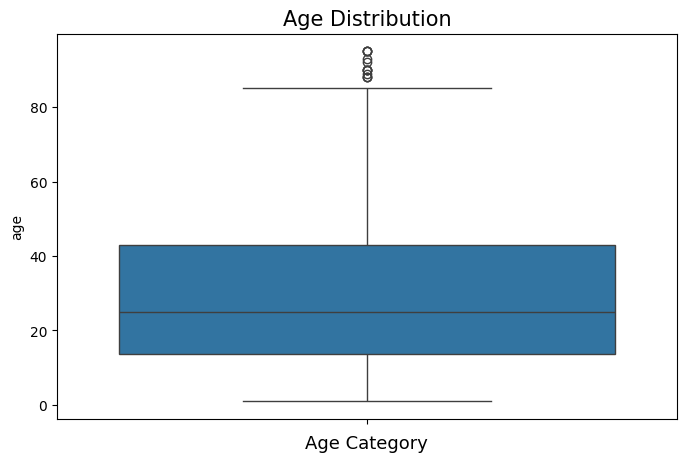

In [377]:
# lokking out for outlier ages among the patients

plt.figure(figsize=(8, 5))
sns.boxplot(df["age"])

plt.xlabel("Age Category", fontsize=13)
plt.title("Age Distribution", fontsize=15);

#### There seem to be some outlier ages above 85 years which we're going to trim off

In [378]:
# Create a filter to trim off the outlier ages, cap max age to 85years and reassign the trimmed data to 'df'

df1 = (df[df["age"] < 86])
df1.head()

,age,test,result,drug,dosage,resistance
0,29,mRDT,NEG,Not ACT,0,0
1,21,mRDT,NEG,Not ACT,0,0
2,42,mRDT,POS,ACT,4,0
3,21,mRDT,NEG,Not ACT,0,0
4,60,mRDT,NEG,Not ACT,0,0


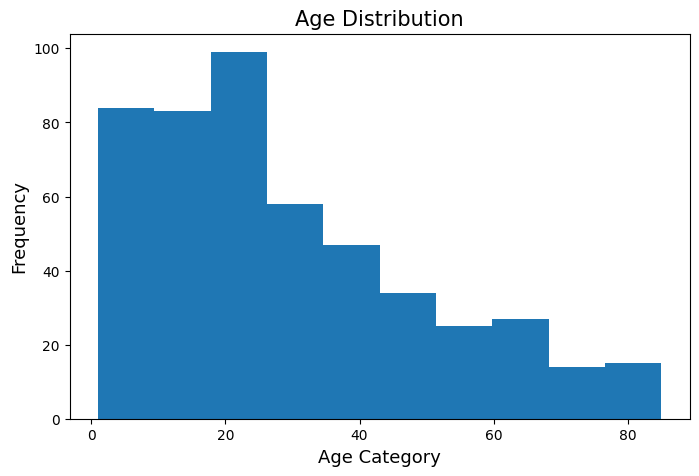

In [379]:
# comment 

plt.figure(figsize=(8, 5))

df1["age"].plot(kind="hist", bins=10)
plt.xlabel("Age Category", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.title("Age Distribution", fontsize=15);

In [380]:
round(df.resistance.value_counts(normalize=True)*100, 2)

resistance
0    68.4
1    31.6
Name: proportion, dtype: float64

#### As could be seen, there is an imbalance in the target class which we need to address before building the model.

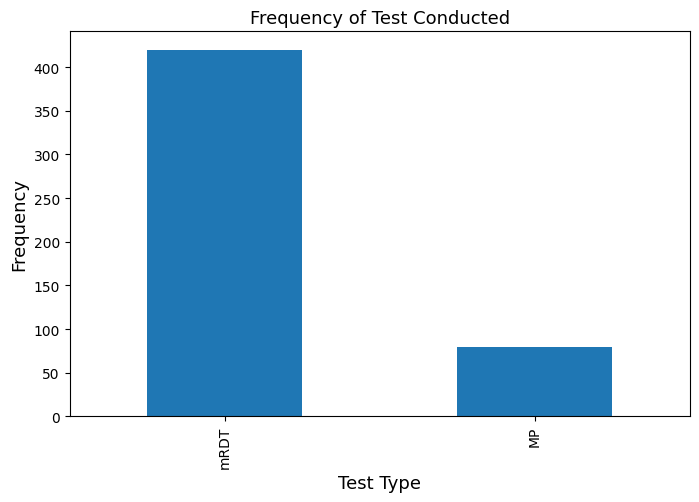

In [381]:
# 

plt.figure(figsize=(8, 5))

df.test.value_counts().plot(kind="bar")
plt.xlabel("Test Type", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.title("Frequency of Test Conducted", fontsize=13);

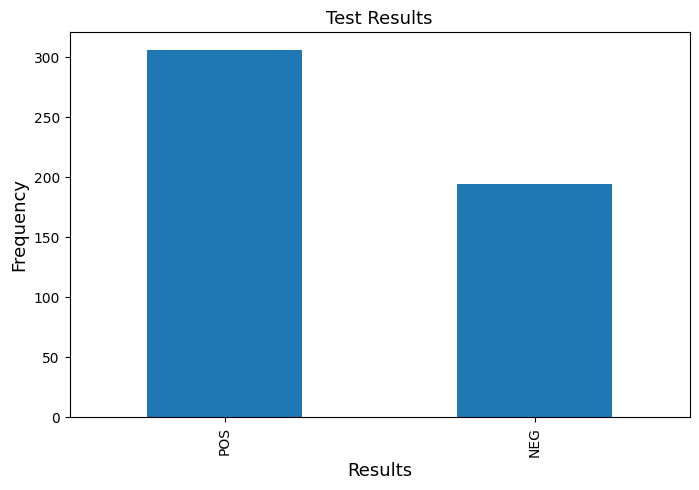

In [382]:
# 

plt.figure(figsize=(8, 5))

df.result.value_counts().plot(kind="bar")
plt.xlabel("Results", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.title("Test Results", fontsize=13);

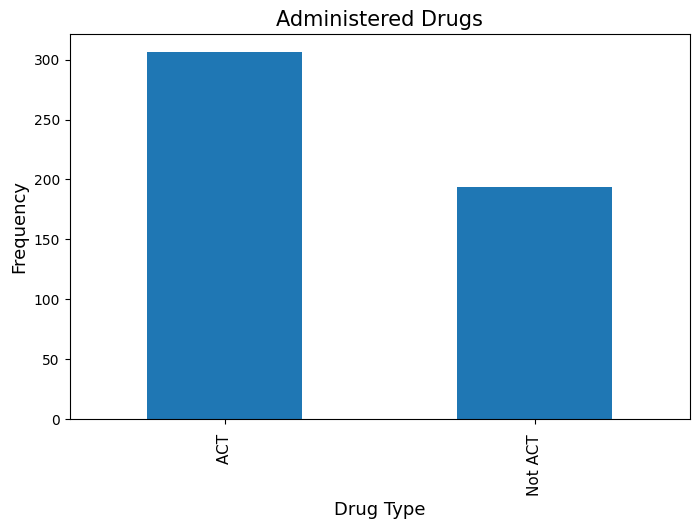

In [383]:
# 

plt.figure(figsize=(8, 5))

df.drug.value_counts().plot(kind="bar", )
plt.xlabel("Drug Type", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.xticks(fontsize=11)
plt.title("Administered Drugs", fontsize=15);

In [384]:
df.dosage.value_counts()

dosage
4    202
0    194
3     49
2     45
1     10
Name: count, dtype: int64

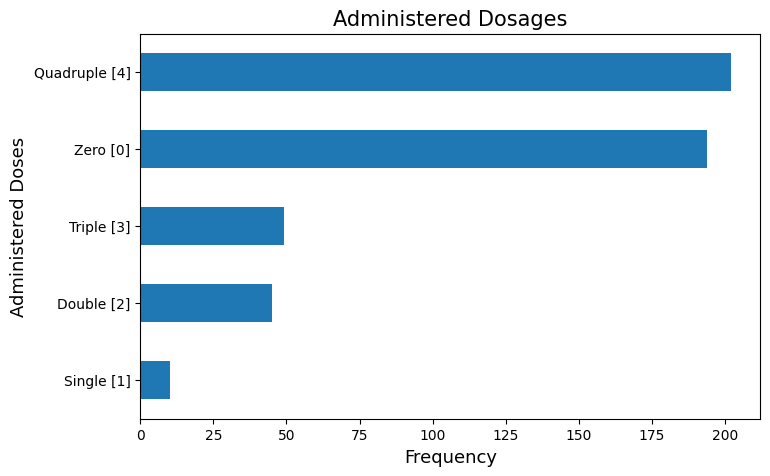

In [385]:
# 

plt.figure(figsize=(8, 5))

df.dosage.value_counts().sort_values().plot(kind="barh")
plt.xlabel("Frequency", fontsize=13)
plt.ylabel("Administered Doses", fontsize=13)
plt.title("Administered Dosages", fontsize=15)
plt.yticks([4, 3, 2, 1, 0], ["Quadruple [4]", "Zero [0]", "Triple [3]", "Double [2]", "Single [1]"]);

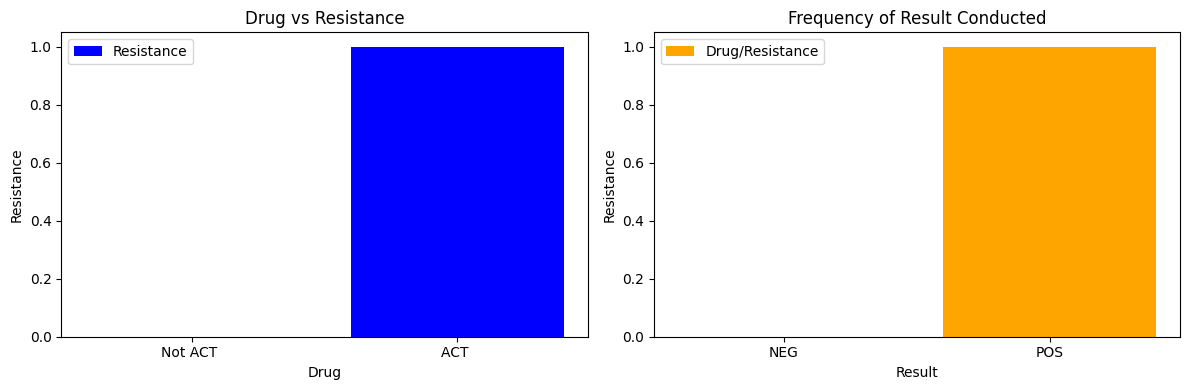

In [386]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# First subplot (bar chart)
axs[0].bar(df["drug"], df["resistance"], color="blue")
axs[0].set_title("Drug vs Resistance")
axs[0].set_xlabel("Drug")
axs[0].set_ylabel("Resistance")
axs[0].legend(["Resistance"])

# Second subplot (bar chart)
axs[1].bar(df["result"], df["resistance"], color="orange")
axs[1].set_title("Frequency of Result Conducted")
axs[1].set_xlabel("Result")
axs[1].set_ylabel("Resistance")
axs[1].legend(["Drug/Resistance"])

plt.tight_layout()
plt.show()


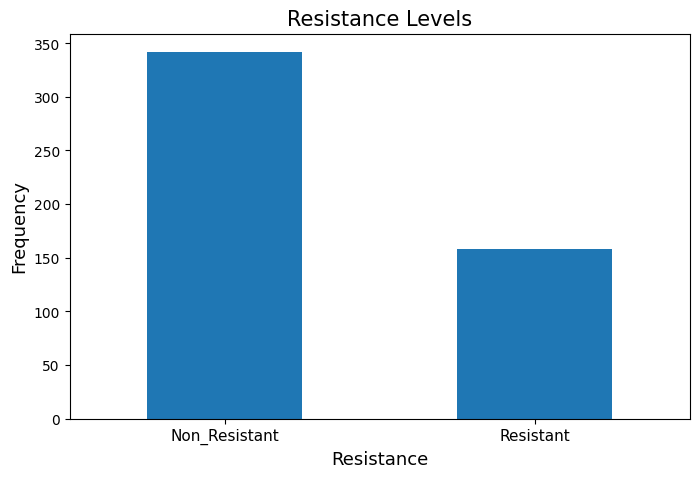

In [387]:
# 

plt.figure(figsize=(8, 5))

df.resistance.value_counts().plot(kind="bar")
plt.xlabel("Resistance", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.xticks([0, 1], ["Non_Resistant", "Resistant"], rotation=360, fontsize=11)
plt.title("Resistance Levels", fontsize=15);

In [388]:
df.result.value_counts()

result
POS    306
NEG    194
Name: count, dtype: int64

<Axes: xlabel='resistance'>

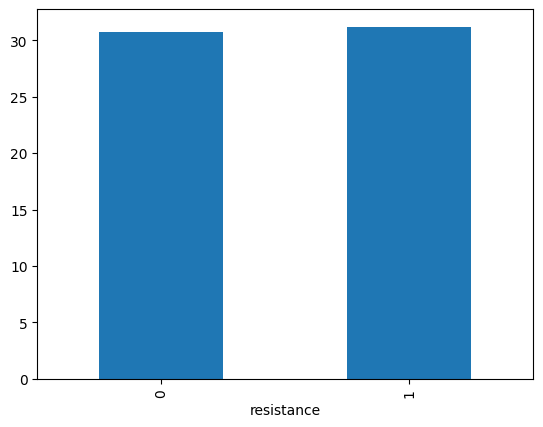

In [389]:
df.groupby('resistance')['age'].mean().plot(kind='bar')

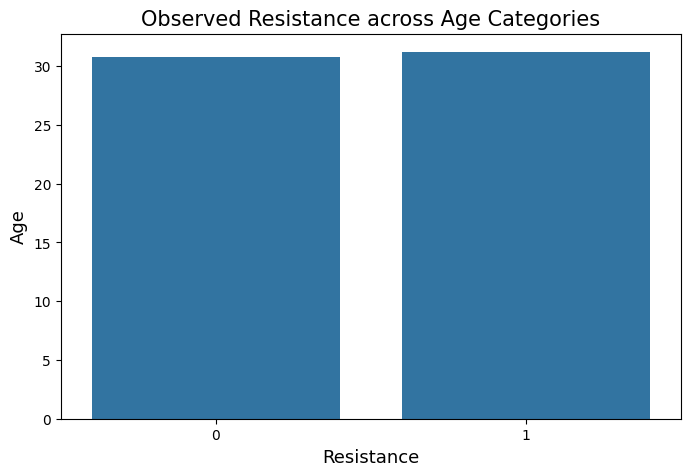

In [390]:
#

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="resistance", y="age", ci=False);

plt.xlabel("Resistance" , fontsize=13)
plt.ylabel("Age", fontsize=13)
plt.title("Observed Resistance across Age Categories", fontsize=15);

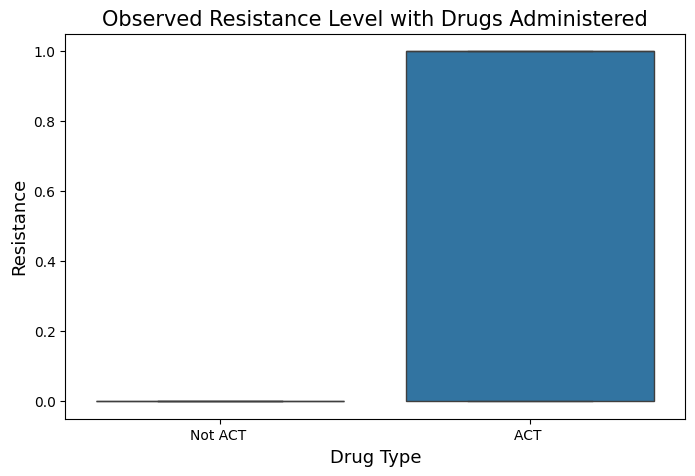

In [391]:
#

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="drug", y="resistance")

plt.xlabel("Drug Type" , fontsize=13)
plt.ylabel("Resistance", fontsize=13)
plt.title("Observed Resistance Level with Drugs Administered", fontsize=15);


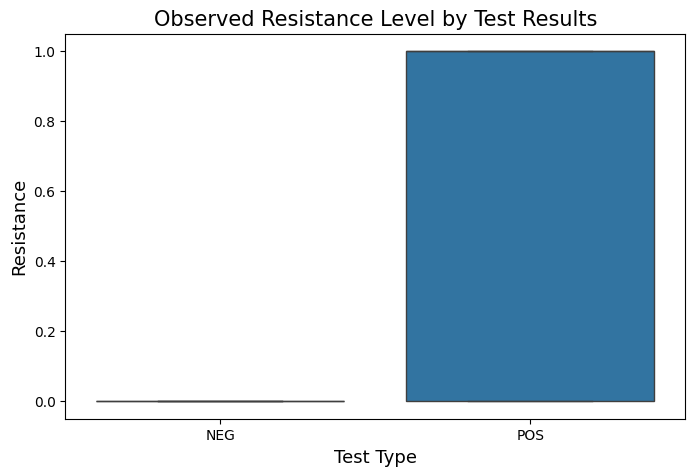

In [392]:
# 

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="result", y="resistance")

plt.xlabel("Test Type" , fontsize=13)
plt.ylabel("Resistance", fontsize=13)
plt.title("Observed Resistance Level by Test Results", fontsize=15);

In [393]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   age         500 non-null    int64 
 1   test        500 non-null    object
 2   result      500 non-null    object
 3   drug        500 non-null    object
 4   dosage      500 non-null    int64 
 5   resistance  500 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 23.6+ KB


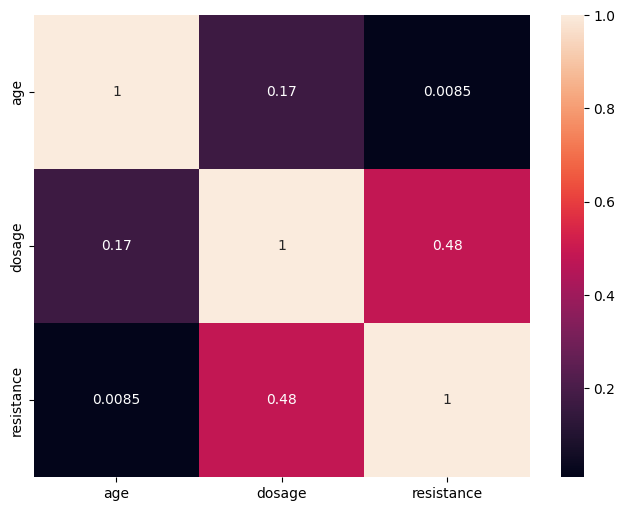

In [394]:
df2 = df.select_dtypes(include=['int', 'float'])
plt.figure(figsize=(8, 6))
sns.heatmap(df2.corr(), annot=True);

In [395]:
df = pd.get_dummies(df, dtype='int')
df

,age,dosage,resistance,test_MP,test_mRDT,result_NEG,result_POS,drug_ACT,drug_Not ACT
0,29,0,0,0,1,1,0,0,1
1,21,0,0,0,1,1,0,0,1
2,42,4,0,0,1,0,1,1,0
3,21,0,0,0,1,1,0,0,1
4,60,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...
495,2,1,0,1,0,0,1,1,0
496,2,2,1,1,0,0,1,1,0
497,62,4,1,1,0,0,1,1,0
498,22,4,1,0,1,0,1,1,0


In [396]:
#encode(df)

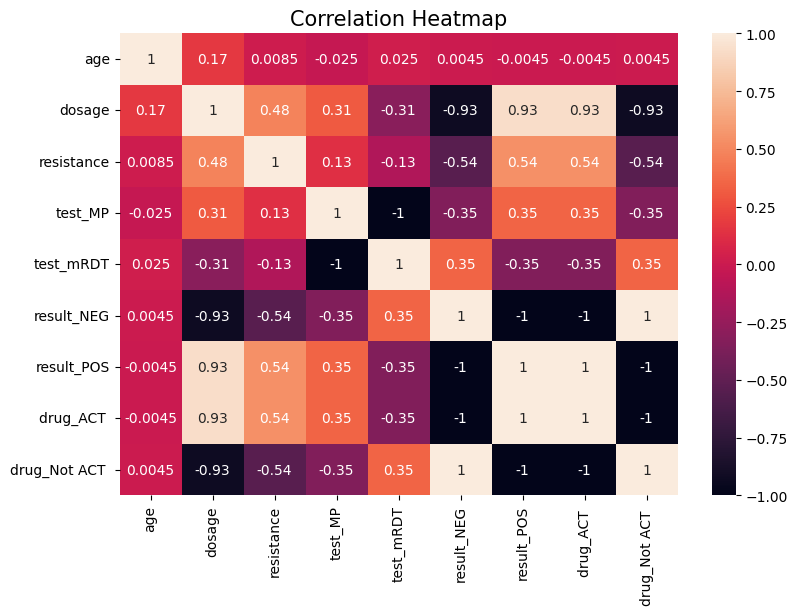

In [397]:
#conducting correlation among all variables
plt.figure(figsize=(9, 6))
sns.heatmap(df.corr(), annot=True)
plt.title("Correlation Heatmap", fontsize=15);

In [398]:
df.head(10)

,age,dosage,resistance,test_MP,test_mRDT,result_NEG,result_POS,drug_ACT,drug_Not ACT
0,29,0,0,0,1,1,0,0,1
1,21,0,0,0,1,1,0,0,1
2,42,4,0,0,1,0,1,1,0
3,21,0,0,0,1,1,0,0,1
4,60,0,0,0,1,1,0,0,1
5,63,4,1,0,1,0,1,1,0
6,22,0,0,0,1,1,0,0,1
7,18,0,0,0,1,1,0,0,1
8,24,0,0,0,1,1,0,0,1
9,19,0,0,0,1,1,0,0,1


In [399]:
#defining the Predictors (X) and Response (y) variables
X = df.drop(["resistance", 'result_POS', 'drug_Not ACT '], axis=1)
#X = df.drop(["resistance"], axis=1)
y = df["resistance"]

In [400]:
# Splitting the target and features into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=11)

In [401]:
df['resistance'].value_counts()

resistance
0    342
1    158
Name: count, dtype: int64

In [402]:
X_train

,age,dosage,test_MP,test_mRDT,result_NEG,drug_ACT
14,6,0,0,1,1,0
493,19,4,0,1,0,1
56,43,0,0,1,1,0
266,19,3,0,1,0,1
179,4,0,0,1,1,0
...,...,...,...,...,...,...
337,37,4,0,1,0,1
91,28,4,0,1,0,1
80,20,0,0,1,1,0
191,50,4,0,1,0,1


In [403]:
# Combine the X_train and y_train to make resampling easier
train_data = pd.concat([X_train, y_train], axis=1)

# Filter for majority and minority classes
majority_class = train_data[train_data['resistance'] == 0]  
minority_class = train_data[train_data['resistance'] == 1]  

# Upsample the minority class
minority_class_upsampled = resample(minority_class,
                                    replace=True,  # Sample with replacement
                                    n_samples=len(majority_class),  # Match majority class size
                                    random_state=11)  # Reproducibility

# Combine the upsampled minority class with the original majority class
upsampled_train_data = pd.concat([majority_class, minority_class_upsampled])

# Separate the features and target again
X_train = upsampled_train_data.drop('resistance', axis=1)
y_train = upsampled_train_data['resistance']

upsampled_train_data['resistance'].value_counts(normalize=True) * 100

resistance
0    50.0
1    50.0
Name: proportion, dtype: float64

In [371]:
X_train

,age,dosage,test_MP,test_mRDT,result_NEG,drug_ACT
14,6,0,0,1,1,0
493,19,4,0,1,0,1
56,43,0,0,1,1,0
266,19,3,0,1,0,1
179,4,0,0,1,1,0
...,...,...,...,...,...,...
40,55,4,0,1,0,1
91,28,4,0,1,0,1
253,19,4,0,1,0,1
455,61,4,1,0,0,1


In [404]:
# building the Baseline model

y_train.value_counts(normalize=True).max()

np.float64(0.5)

The above baseline model score is what we'd look forward to beating

In [ ]:
# Instantiating imported models

logreg = LogisticRegression(random_state=11, n_jobs=-1, )
tree = DecisionTreeClassifier(random_state=11)
forest = RandomForestClassifier(n_jobs=-1, random_state=11)
bag = BaggingClassifier(n_estimators=13, n_jobs=-1, random_state=11)
vote = VotingClassifier(estimators=[("forest", forest), ("logistics", logreg)], n_jobs=-1)

'models = [logreg, tree, forest, bag, vote]\nfor i in models:\n    i.fit(X_train, y_train)'

In [406]:
# Building a function to fit instantiated models above and 
# return their respective classifications and confusion matrix on the test set

def compute(model):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    conf_m = classification_report(y_test, y_pred)
    output = print("Model test Accuracy:", test_acc, '\n\n', conf_m)

    return output


In [407]:
compute(logreg)

Model test Accuracy: 0.74 

               precision    recall  f1-score   support

           0       1.00      0.61      0.75        66
           1       0.57      1.00      0.72        34

    accuracy                           0.74       100
   macro avg       0.78      0.80      0.74       100
weighted avg       0.85      0.74      0.74       100



{'C': 0.1,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'n_jobs': -1,
 'penalty': 'l1',
 'solver': 'saga',
 'tol': 0.0001}

In [408]:
compute(tree)

Model test Accuracy: 0.61 

               precision    recall  f1-score   support

           0       0.70      0.71      0.71        66
           1       0.42      0.41      0.42        34

    accuracy                           0.61       100
   macro avg       0.56      0.56      0.56       100
weighted avg       0.61      0.61      0.61       100



In [409]:
compute(forest)

Model test Accuracy: 0.66 

               precision    recall  f1-score   support

           0       0.76      0.71      0.73        66
           1       0.50      0.56      0.53        34

    accuracy                           0.66       100
   macro avg       0.63      0.64      0.63       100
weighted avg       0.67      0.66      0.66       100



In [410]:
compute(bag)

Model test Accuracy: 0.63 

               precision    recall  f1-score   support

           0       0.72      0.73      0.72        66
           1       0.45      0.44      0.45        34

    accuracy                           0.63       100
   macro avg       0.59      0.58      0.58       100
weighted avg       0.63      0.63      0.63       100



In [411]:
compute(vote)

Model test Accuracy: 0.66 

               precision    recall  f1-score   support

           0       0.76      0.71      0.73        66
           1       0.50      0.56      0.53        34

    accuracy                           0.66       100
   macro avg       0.63      0.64      0.63       100
weighted avg       0.67      0.66      0.66       100



In [412]:
params = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'tol': [0.0001, 0.01, 0.1, 1, 10],
    'C': [0.1, 1.0, 10],
    'intercept_scaling': [0, 1],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [50, 100, 200],
    'multi_class': ['deprecated', 'ovr', 'multinomial']   
}
grid = GridSearchCV(estimator=logreg,param_grid=params, cv=5, n_jobs=-1)

##### Note! The below code would take on the average, 90secs to run (depending on machine)

In [413]:
grid.fit(X_train, y_train)
grid.predict(X_test)


array([1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1])

In [ ]:
classification(logreg)

Model test Accuracy: 0.74 

               precision    recall  f1-score   support

           0       1.00      0.61      0.75        66
           1       0.57      1.00      0.72        34

    accuracy                           0.74       100
   macro avg       0.78      0.80      0.74       100
weighted avg       0.85      0.74      0.74       100



In [415]:
y_pred = grid.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
conf_m = classification_report(y_test, y_pred)
output = print("Model test Accuracy:", test_acc, '\n\n', conf_m)

Model test Accuracy: 0.74 

               precision    recall  f1-score   support

           0       1.00      0.61      0.75        66
           1       0.57      1.00      0.72        34

    accuracy                           0.74       100
   macro avg       0.78      0.80      0.74       100
weighted avg       0.85      0.74      0.74       100



In [475]:
models = {"Logistic Regression": logreg, "Decision Tree": tree, "Random Forest": forest, "Bagging Ensemble": bag, "Voting Ensemble": vote, "GridSearchCV": grid}
res = []
for i, j in models.items():
    y_pred = j.predict(X_test)
    accur = accuracy_score(y_test, y_pred)
    res.append({'Model':i, 'Accuracy':accur})
    #res = res. 
print(pd.DataFrame(res).sort_values('Accuracy', ascending=False))

                 Model  Accuracy
0  Logistic Regression      0.74
5         GridSearchCV      0.74
4      Voting Ensemble      0.66
2        Random Forest      0.66
3     Bagging Ensemble      0.63
1        Decision Tree      0.61


In [ ]:
mod = ["Logistics", "Decision Tree", "Random Forest", "Bagging", "Voting"]
tab = pd.DataFrame(model, )

'Voting | 0.66'

In [449]:
accur

0.66

In [ ]:
y = alpha + BXi + Ei

In [418]:
importances = logreg.coef_[0]
importances

array([ 0.00503238,  0.03677199, -0.24841152,  0.24803428, -2.4577072 ,
        2.45732996])

In [419]:
feat_n = X.columns.str.capitalize()
feat_n

Index(['Age', 'Dosage', 'Test_mp', 'Test_mrdt', 'Result_neg', 'Drug_act '], dtype='object')

In [420]:
merge = pd.Series(importances, feat_n)
merge

Age           0.005032
Dosage        0.036772
Test_mp      -0.248412
Test_mrdt     0.248034
Result_neg   -2.457707
Drug_act      2.457330
dtype: float64

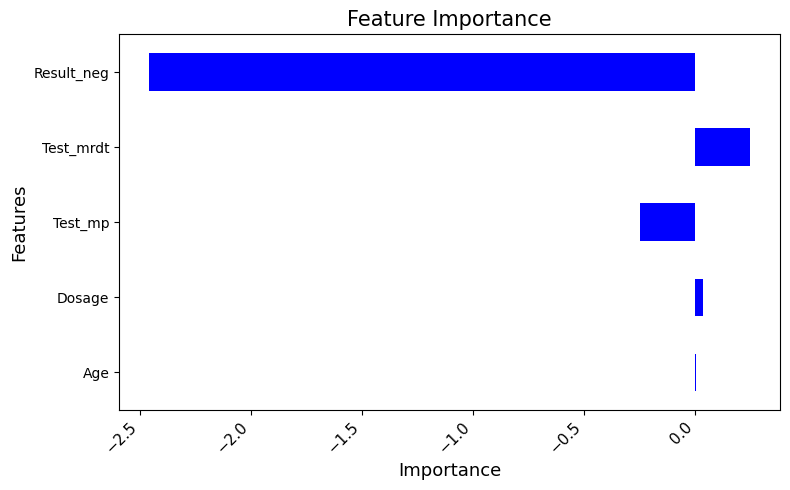

In [421]:
plt.figure(figsize=(8, 5))
merge.head(5).plot(kind='barh', color='blue')
plt.title('Feature Importance', fontsize=15)
plt.ylabel('Features', fontsize=13)
plt.xlabel('Importance', fontsize=13)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))

tree.plot_tree(tree, filled=True, feature_names=importances, class_names=y.name)
plt.show()

In [ ]:
with open("Pickle_file.pkl", "wb") as f:
    model = pickle.dump(tree, f)